In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from nsdmd import utils
from nsdmd import nsdmd

In [2]:
sr = 1000
f1 = 4
t1 = np.arange(-500,1200)+500
f2 = 30
t2 = np.arange(-500,1200)+500
f3 = 17
t3 = np.arange(800,2500)+500
f4 = 30
t4 = np.arange(800,2500)+500

net1, F1_true, _ = utils.make_network(f1, len(t1), \
                    np.hstack([i*np.ones(50) for i in [1,2]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(0,30,10)]]),\
                    sr, \
                    utils.create_decay(len(t1),1,400))
net2, F2_true, _  = utils.make_network(f2, len(t2), \
                    np.hstack([i*np.ones(50) for i in [1,2]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(-20,30,10)]]),\
                    sr, \
                    utils.create_decay(len(t2),1,400))
net3, F3_true, _  = utils.make_network(f3, len(t3), \
                    np.hstack([i*np.ones(50) for i in [2,1]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(50,0,10)]]),\
                    sr, \
                    utils.create_decay(len(t3),400,1))
gauss = scipy.stats.norm(800, 200).pdf(np.arange(1700))
gauss = gauss / np.max(gauss) + 0.3
net4, F4_true, _  = utils.make_network(f4, len(t4), \
                    np.hstack([i*np.ones(50) for i in [2,1]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(30,-10,10)]]),\
                    sr, \
                    gauss*utils.create_decay(len(t4),400,1))
x = np.zeros((100,3000))
x[:,t1] += net1
x[:,t2] += net2
x[:,t3] += net3
x[:,t4] += net4
x = utils.add_noise(x, std=0.1)
t = np.arange(x.shape[1]) / sr

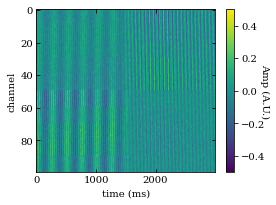

In [3]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

cax = ax.imshow(x, aspect='auto', vmin=-0.5, vmax=0.5)
cbar = fig.colorbar(cax)
cbar.set_label('Amp (A.U.)', rotation=270)
ax.set_xlabel('time (ms)')
ax.set_ylabel('channel')
# plt.savefig('figs/two_net_x.svg', bbox_inches='tight')

In [105]:
model = nsdmd.NSDMD(opt_rank=4, sim_thresh_phi_amp=0.92, grad_alpha=0.1)
model.fit_opt(x, t, sr)

# model = nsdmd.NSDMD(opt_rank=2, sim_thresh_phi_amp=0.97, grad_alpha=0.1) #for 2 mode 30 hz guess
# model.fit_opt(x, t, sr, np.array([30,-30]))
#for rank of 6, use f_method='grad'

Text(0, 0.5, 'freq (Hz)')

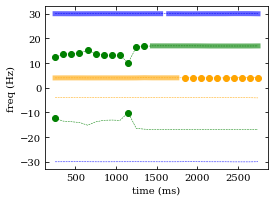

In [115]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

group_idx = nsdmd.group_by_similarity(model.freqs_, model.phis_, \
                                      model.sim_thresh_freq, model.sim_thresh_phi_amp)

x_extent = np.mean(model.windows_, axis=1)
colors = ['blue', 'orange', 'green', 'red']
for i in range(len(group_idx)):
    ax.plot(x_extent, model.freqs_[:,i], linestyle='dashed', color=colors[i//2], linewidth=0.5)
    for g in group_idx[i]:
        if(len(g)>1):
            ax.plot(x_extent[g], model.freqs_[g,i], color=colors[i//2], linewidth=5, alpha=0.6)
        else:
            ax.scatter(x_extent[g], model.freqs_[g,i], color=colors[i//2])
ax.set_xlabel('time (ms)')
ax.set_ylabel('freq (Hz)')
# plt.savefig('figs/two_net_similar.svg', bbox_inches='tight')
# plt.savefig('figs/two_net_similar_6.svg', bbox_inches='tight')

In [112]:
model.fit_reduction(x, len(t), sr)

Gathering modes...
Found 28 modes
Number of modes: 28/28, stopping at 0
Number of modes: 27/28, stopping at 0
Number of modes: 26/28, stopping at 0
Number of modes: 25/28, stopping at 0
Number of modes: 24/28, stopping at 0
Number of modes: 23/28, stopping at 0
Number of modes: 22/28, stopping at 0
Number of modes: 21/28, stopping at 0
Number of modes: 20/28, stopping at 0
Number of modes: 19/28, stopping at 0
Number of modes: 18/28, stopping at 0
Number of modes: 17/28, stopping at 0
Number of modes: 16/28, stopping at 0
Number of modes: 15/28, stopping at 0
Number of modes: 14/28, stopping at 0
Number of modes: 13/28, stopping at 0
Number of modes: 12/28, stopping at 0
Number of modes: 11/28, stopping at 0
Number of modes: 10/28, stopping at 0
Number of modes: 9/28, stopping at 0
Number of modes: 8/28, stopping at 0
Number of modes: 7/28, stopping at 0
Number of modes: 6/28, stopping at 0
Number of modes: 5/28, stopping at 0
Number of modes: 4/28, stopping at 0
Number of modes: 3/28,

Text(0, 0.5, 'Cosine Distance')

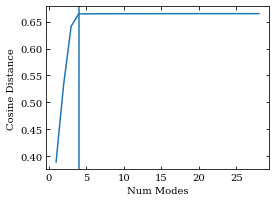

In [113]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

ax.plot(model.num_modes_, model.errors_)
ax.axvline(4)
ax.set_xlabel('Num Modes')
ax.set_ylabel('Cosine Distance')
# plt.savefig('figs/two_net_cosine.svg', bbox_inches='tight')

In [116]:
model.fit_f(x, len(t), sr, 4)

/tmp/ipykernel_1320/2092082735.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + alpha)


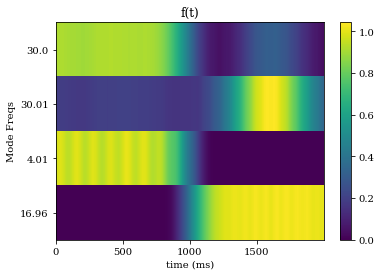

In [117]:
alpha = [str(np.round(f,2)) for f in model.freq_mean_]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(model.f_hat_[:,500:-500], aspect='auto')
fig.colorbar(cax)
ax.set_yticklabels([''] + alpha)
ax.xaxis.set_ticks_position('bottom')
plt.title('f(t)')
plt.xlabel('time (ms)')
plt.ylabel('Mode Freqs')
plt.show()

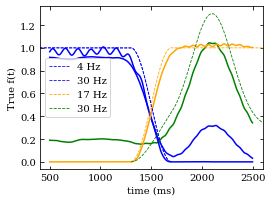

In [119]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

colors = ['blue', 'green', 'blue', 'orange', 'blue', 'green']
for i,f in enumerate(model.f_hat_[:,500:-500]):
    ax.plot(np.arange(500,2500), f, color=colors[i])

ax.plot(t1, np.mean(F1_true, axis=0), color=colors[2], label=str(f1)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t2, np.mean(F2_true, axis=0), color=colors[0], label=str(f2)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t3, np.mean(F3_true, axis=0), color=colors[3], label=str(f3)+' Hz', linestyle='dashed', linewidth=0.8)
ax.plot(t4, np.mean(F4_true, axis=0), color=colors[1], label=str(f4)+' Hz', linestyle='dashed', linewidth=0.8)
ax.legend()
ax.set_xlim(400,2600)
ax.set_xlabel('time (ms)')
ax.set_ylabel('True f(t)')
# plt.savefig('figs/two_net_f.svg', bbox_inches='tight')
# plt.savefig('figs/two_net_f_4.svg', bbox_inches='tight')
# plt.savefig('figs/two_net_f_30.svg', bbox_inches='tight')
# plt.savefig('figs/two_net_f_6_modes.svg', bbox_inches='tight')

In [11]:
x_rec = model.transform(x, len(t), sr)

Text(0, 0.5, 'Channel')

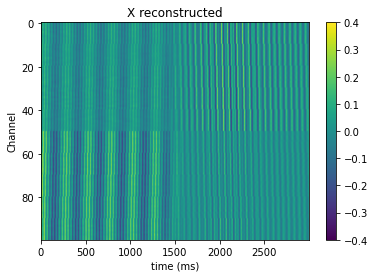

In [12]:
plt.imshow(x_rec, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X reconstructed')
plt.xlabel('time (ms)')
plt.ylabel('Channel')

Text(0, 0.5, 'Channel')

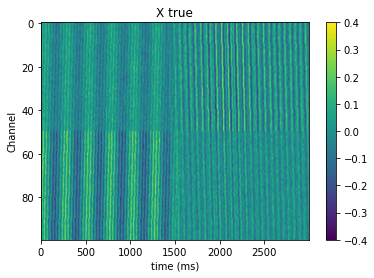

In [13]:
plt.imshow(x, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X true')
plt.xlabel('time (ms)')
plt.ylabel('Channel')